# **Import libraries**

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import osgeo
import re
import itertools

from itertools import groupby,count

---
# **Raw data**
---

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/718C_final/NG-718C_final.xlsx', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPTH   2668 non-null   float64
 1   SGR     2668 non-null   float64
 2   CGR     2668 non-null   float64
 3   THOR    2668 non-null   float64
 4   URAN    2668 non-null   float64
 5   POTA    2668 non-null   float64
 6   DTLN    2668 non-null   float64
 7   DTLF    2668 non-null   float64
 8   RHOB    2668 non-null   float64
 9   PEF     2668 non-null   float64
 10  DRHO    2668 non-null   float64
 11  ILD     2668 non-null   float64
 12  ILM     2668 non-null   float64
 13  SFLU    2668 non-null   float64
dtypes: float64(14)
memory usage: 291.9 KB


In [ ]:
df.describe()

,DEPTH,SGR,CGR,THOR,URAN,POTA,DTLN,DTLF,RHOB,PEF,DRHO,ILD,ILM,SFLU
count,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000
mean,331.241400,88.107749,63.210888,10.432501,2.812663,1.619028,163.572092,163.608067,2.766713,3.251559,0.934409,2.766713,3.251559,0.934409
std,117.398228,22.238973,11.934827,1.987994,2.498223,0.359761,19.218049,19.225641,0.232324,0.528163,0.058759,0.232324,0.528163,0.058759
min,128.016000,30.912800,22.743700,2.738200,-0.750300,0.498100,122.881400,124.252200,2.261700,2.074200,0.792000,2.261700,2.074200,0.792000
25%,229.628700,77.209375,55.670775,9.279775,1.766550,1.372925,147.913950,147.980700,2.539075,2.845200,0.883300,2.539075,2.845200,0.883300
50%,331.241400,86.654050,64.363250,10.632450,2.333750,1.644500,159.525700,159.529550,2.849600,3.279300,0.935750,2.849600,3.279300,0.935750
75%,432.854100,96.169250,71.885375,11.734725,3.053275,1.875625,176.469575,176.147325,2.966800,3.615775,0.980000,2.966800,3.615775,0.980000
max,534.466800,277.035700,104.023600,17.831400,24.974200,2.915200,205.642400,206.998000,3.121100,4.660100,1.110400,3.121100,4.660100,1.110400


In [ ]:
df.isna().sum()

DEPTH    0
SGR      0
CGR      0
THOR     0
URAN     0
POTA     0
DTLN     0
DTLF     0
RHOB     0
PEF      0
DRHO     0
ILD      0
ILM      0
SFLU     0
dtype: int64

In [ ]:
df.to_excel("facies for 718C.xlsx")

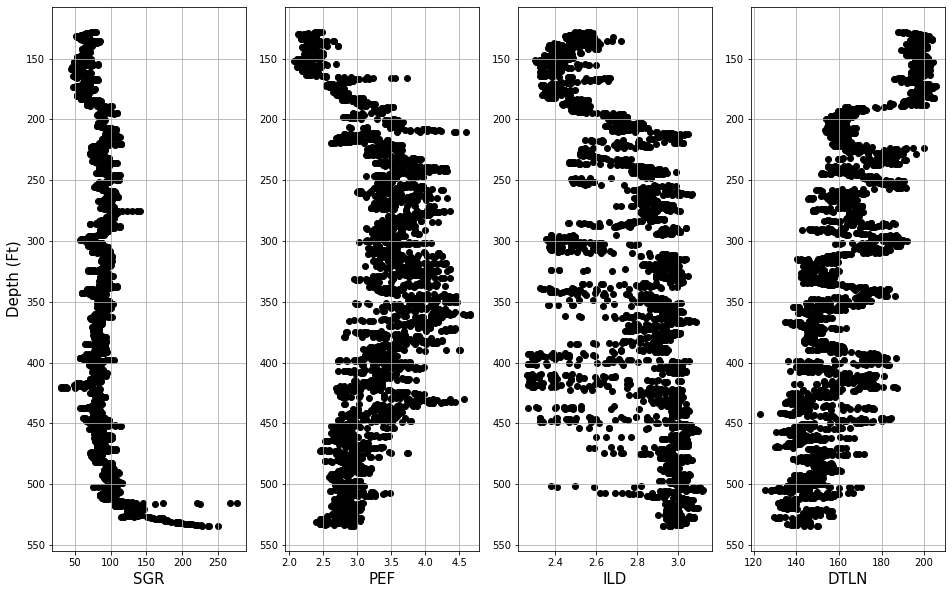

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(16,10),linewidth=3)

curves = ['SGR','PEF','ILD','DTLN']

for i in range(len(curves)):
    ax[i].scatter(df[curves[i]],df['DEPTH'],c='k')
    ax[i].set_xlabel(curves[i],fontsize=15)
    ax[0].set_ylabel('Depth (Ft)',fontsize=15)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(True)
    ax[i].invert_yaxis()

### **Petrophysical properties**

In [ ]:
def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min):
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min)
    #vshale = vshale / (3 - 2 * vshale)
    vshale = 0.083 * (2 ** (2 * 3.7 * vshale  ) - 1) #for teritary rocks
    return round(vshale, 4)

In [ ]:
#Calculate Shale Volume
df['VSHALE'] = shale_volume(df['CGR'], df['CGR'].max(),df['CGR'].min())

In [ ]:
def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [ ]:
#Calculate density porosity
df['PHI'] = density_porosity(df['RHOB'], 2.65, 1)

In [ ]:
#Calculate PHIE
df['PHIECALC'] = df['PHI'] - (df['VSHALE'] * 0.3)

In [ ]:
df['Log_ILD'] = np.log(df['ILD'])

In [ ]:
fe = pd.DataFrame()
fe = df.drop(columns=['DRHO', 'URAN','THOR','ILM','SFLU','CGR', 'DTLF', 'POTA', 'DEPTH', 'Log_ILD', 'PHI'])

features = fe

In [ ]:
df['DEPTH']

0       128.0160
1       128.1684
2       128.3208
3       128.4732
4       128.6256
          ...   
2663    533.8572
2664    534.0096
2665    534.1620
2666    534.3144
2667    534.4668
Name: DEPTH, Length: 2668, dtype: float64

In [ ]:
features.corr()

,SGR,DTLN,RHOB,PEF,ILD,VSHALE,PHIECALC
SGR,1.000000,-0.514108,0.512412,0.074236,0.512412,0.295264,-0.435495
DTLN,-0.514108,1.000000,-0.810777,-0.305181,-0.810777,-0.221706,0.486300
RHOB,0.512412,-0.810777,1.000000,0.190271,1.000000,0.287931,-0.611761
PEF,0.074236,-0.305181,0.190271,1.000000,0.190271,0.269402,-0.293676
ILD,0.512412,-0.810777,1.000000,0.190271,1.000000,0.287931,-0.611761
VSHALE,0.295264,-0.221706,0.287931,0.269402,0.287931,1.000000,-0.933688
PHIECALC,-0.435495,0.486300,-0.611761,-0.293676,-0.611761,-0.933688,1.000000


# **K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [ ]:
x_scaled = scale(features)
x_scaled

array([[-0.37036301,  1.25182933, -1.07246885, ..., -1.07246885,
        -1.18801316,  1.38223636],
       [-0.53023398,  1.38841406, -1.16502945, ..., -1.16502945,
        -0.74416337,  1.05040178],
       [-0.67137756,  1.27462988, -0.91274801, ..., -0.91274801,
        -0.41848702,  0.68709166],
       ...,
       [ 6.64374844, -0.88513046,  0.84461184, ...,  0.84461184,
        -1.21917236,  0.69134152],
       [ 6.72815215, -0.70957506,  0.68489099, ...,  0.68489099,
        -1.22332049,  0.75426605],
       [ 7.24470716, -0.70640036,  0.6762807 , ...,  0.6762807 ,
        -1.21917236,  0.75429261]])

In [ ]:
wcss = []

cl_num = 12
for i in range (1,cl_num):
    kmeans= KMeans(i, random_state=10)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

[18676.00000000004,
 10310.98678842267,
 8350.891845538401,
 6948.863729630617,
 5872.449933300253,
 4879.020720892093,
 4378.947495854727,
 3995.567999177703,
 3714.4254414570487,
 3451.1168372122374,
 3236.514767397065]

Text(0, 0.5, 'Within-cluster Sum of Squares')

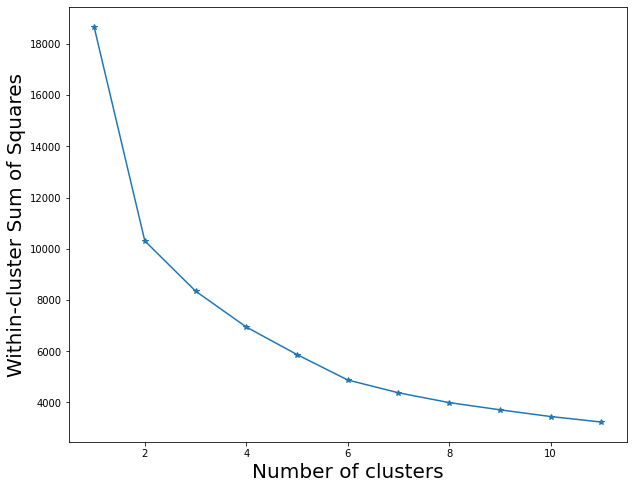

In [ ]:
number_clusters = range(1,cl_num)
plt.figure(figsize=(10,8))
plt.plot(number_clusters, wcss,'*-' )
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Within-cluster Sum of Squares',fontsize=20)

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,11]

for n_clusters  in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)

    silhouette_avg = silhouette_score(x_scaled, cluster_labels)

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.4339313312039957


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.3369769954848004


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.316554580852109


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.3249304436319782


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.3165306589951678


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.3163495521094579


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.3064050097676715


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.30145997024642024


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.2958766687891079


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11 The average silhouette_score is : 0.2771401288387819


In [ ]:
cls_name = 5

---
# **Node Dataset**
---

In [ ]:
df['Facies_pred'] = ''
kmeans_ = KMeans(cls_name,n_init=100)
kmeans_.fit(x_scaled)
df['Facies_pred'] =kmeans_.fit_predict(x_scaled)

In [ ]:
f = df['Facies_pred']

In [ ]:
#df.to_excel("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/facies for "+ str(cls_name) +".xlsx")

In [ ]:
df.columns

Index(['DEPTH', 'SGR', 'CGR', 'THOR', 'URAN', 'POTA', 'DTLN', 'DTLF', 'RHOB',
       'PEF', 'DRHO', 'ILD', 'ILM', 'SFLU', 'VSHALE', 'PHI', 'PHIECALC',
       'Log_ILD', 'Facies_pred'],
      dtype='object')

In [ ]:
df = ''
cls_name = 8
df = pd.read_excel("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/facies for "+ str(cls_name) +".xlsx")

### **Split cluster range**

In [ ]:
fr1 = []
fr2 = []
a1 = df['Facies_pred'].to_list()
l1 = [idx for idx,value in enumerate(a1) if value == 0]
hwe1 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
for i in range(len(hwe1)):
  fr1.append(df['DEPTH'][hwe1[i][0]])
  fr2.append(df['DEPTH'][hwe1[i][-1]])

se1 = []
se2 = []
a2 = df['Facies_pred'].to_list()
l1 = [idx for idx,value in enumerate(a2) if value == 1]
hwe2 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
for i in range(len(hwe2)):
  se1.append(df['DEPTH'][hwe2[i][0]])
  se2.append(df['DEPTH'][hwe2[i][-1]])

th1 = []
th2 = []
a3 = df['Facies_pred'].to_list()
l1 = [idx for idx,value in enumerate(a3) if value == 2]
hwe3 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
for i in range(len(hwe3)):
  th1.append(df['DEPTH'][hwe3[i][0]])
  th2.append(df['DEPTH'][hwe3[i][-1]])

fo1 = []
fo2 = []
a4 = df['Facies_pred'].to_list()
l1 = [idx for idx,value in enumerate(a4) if value == 3]
hwe4 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
for i in range(len(hwe4)):
  fo1.append(df['DEPTH'][hwe4[i][0]])
  fo2.append(df['DEPTH'][hwe4[i][-1]])

fi1 = []
fi2 = []
a5 = df['Facies_pred'].to_list()
l1 = [idx for idx,value in enumerate(a5) if value == 4]
hwe5 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
for i in range(len(hwe5)):
  fi1.append(df['DEPTH'][hwe5[i][0]])
  fi2.append(df['DEPTH'][hwe5[i][-1]])

if cls_name > 5:
  si1 = []
  si2 = []
  a6 = df['Facies_pred'].to_list()
  l1 = [idx for idx,value in enumerate(a6) if value == 5]
  hwe6 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
  for i in range(len(hwe6)):
    si1.append(df['DEPTH'][hwe6[i][0]])
    si2.append(df['DEPTH'][hwe6[i][-1]])

if cls_name > 6:
  se1 = []
  se2 = []
  a7 = df['Facies_pred'].to_list()
  l1 = [idx for idx,value in enumerate(a7) if value == 6]
  hwe7 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
  for i in range(len(hwe7)):
    se1.append(df['DEPTH'][hwe7[i][0]])
    se2.append(df['DEPTH'][hwe7[i][-1]])

if cls_name > 7:
  ei1 = []
  ei2 = []
  a8 = df['Facies_pred'].to_list()
  l1 = [idx for idx,value in enumerate(a8) if value == 7]
  hwe8 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
  for i in range(len(hwe8)):
    ei1.append(df['DEPTH'][hwe8[i][0]])
    ei2.append(df['DEPTH'][hwe8[i][-1]])

if cls_name > 8:
  ni1 = []
  ni2 = []
  a9 = df['Facies_pred'].to_list()
  l1 = [idx for idx,value in enumerate(a9) if value == 8]
  hwe9 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
  for i in range(len(hwe9)):
    ni1.append(df['DEPTH'][hwe9[i][0]])
    ni2.append(df['DEPTH'][hwe9[i][-1]])

if cls_name > 9:
  te1 = []
  te2 = []
  a10 = df['Facies_pred'].to_list()
  l1 = [idx for idx,value in enumerate(a10) if value == 9]
  hwe10 = [list(g) for _,g in groupby(l1,key=lambda n,c=count():n-next(c))]
  for i in range(len(hwe10)):
    te1.append(df['DEPTH'][hwe10[i][0]])
    te2.append(df['DEPTH'][hwe10[i][-1]])

In [ ]:
if cls_name == 5:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5
  total_dept == len(tt_dept)
elif cls_name == 6:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5) + len(hwe6)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5 + hwe6
  total_dept == len(tt_dept)
elif cls_name == 7:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5) + len(hwe6) + len(hwe7)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5 + hwe6 + hwe7
  total_dept == len(tt_dept)
elif cls_name == 8:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5) + len(hwe6) + len(hwe7) + len(hwe8)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5 + hwe6 + hwe7 + hwe8
  total_dept == len(tt_dept)
elif cls_name == 9:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5) + len(hwe6) + len(hwe7) + len(hwe8) + len(hwe9)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5 + hwe6 + hwe7 + hwe8 + hwe9
  total_dept == len(tt_dept)
elif cls_name == 10:
  total_dept = len(hwe1) + len(hwe2) + len(hwe3) + len(hwe4) + len(hwe5) + len(hwe6) + len(hwe7) + len(hwe8) + len(hwe9) + len(hwe10)
  tt_dept = hwe1 + hwe2 + hwe3 + hwe4 + hwe5 + hwe6 + hwe7 + hwe8 + hwe9 + hwe10
  total_dept == len(tt_dept)

In [ ]:
tv = sorted(tt_dept)

In [ ]:
len(tv)

324

In [ ]:
tv_start = []
tv_end = []
for i in range(len(tv)):
  tv_start.append(tv[i][0])
  tv_end.append(tv[i][-1])

In [ ]:
tv_final = pd.DataFrame({'clustering_start': tv_start,'clustering_end':tv_end})
#tv_final.to_excel("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/clustering range "+ str(cls_name) +".xlsx")

#Interpreting the results

##### Note: Which is only applicable after getting the results

In [ ]:
results = pd.read_excel("/content/drive/MyDrive/paper final/GCN datasets/"+str(cls_name)+"/results/Results_"+str(cls_name)+".xlsx")

In [ ]:
res_final = pd.DataFrame(index=range(len(tv_start)))
res_final['Clustering_start'] = tv_start
res_final['Clustering_end'] = tv_end
res_final['T_Very_High'] = ''
res_final['T_High'] = ''
res_final['T_Moderate'] = ''
res_final['T_Very_Low'] = ''
res_final['T_Low'] = ''

res_final['P_Very_High'] = ''
res_final['P_High'] = ''
res_final['P_Moderate'] = ''
res_final['P_Very_Low'] = ''
res_final['P_Low'] = ''

if len(tv_start) == len(tv_end):
  for i in range(len(tv_start)):
    if (tv_end[i] - tv_start[i]) != 0:
      #print(results['True'][tv_start[i]:tv_end[i]].value_counts())
      g1 = results[tv_start[i]:tv_end[i]].groupby('True').size()
      g2 = results[tv_start[i]:tv_end[i]].groupby('Predicted').size()
      he1 = []
      he2 = []
      for ind1, val1 in g1.iteritems():
        he1.append(ind1)

      for ind2, val2 in g2.iteritems():
        he2.append(ind2)

      if "Moderate" in he1:
        res_final['T_Moderate'][i] = g1['Moderate']
      else:
        res_final['T_Moderate'][i] = 0

      if "Low" in he1:
        res_final['T_Low'][i] = g1['Low']
      else:
        res_final['T_Low'][i] = 0

      if "Very_Low" in he1:
        res_final['T_Very_Low'][i] = g1['Very_Low']
      else:
        res_final['T_Very_Low'][i] = 0

      if "Very_High" in he1:
        res_final['T_Very_High'][i] = g1['Very_High']
      else:
        res_final['T_Very_High'][i] = 0

      if "High" in he1:
        res_final['T_High'][i] = g1['High']
      else:
        res_final['T_High'][i] = 0

      if "Moderate" in he2:
        res_final['P_Moderate'][i] = g2['Moderate']
      else:
        res_final['P_Moderate'][i] = 0

      if "Low" in he2:
        res_final['P_Low'][i] = g2['Low']
      else:
        res_final['P_Low'][i] = 0

      if "Very_Low" in he2:
        res_final['P_Very_Low'][i] = g2['Very_Low']
      else:
        res_final['P_Very_Low'][i] = 0

      if "Very_High" in he2:
        res_final['P_Very_High'][i] = g2['Very_High']
      else:
        res_final['P_Very_High'][i] = 0

      if "High" in he2:
        res_final['P_High'][i] = g2['High']
      else:
        res_final['P_High'][i] = 0

Streaming output truncated to the last 5000 lines.
<ipython-input-62-111d4fd23707>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_final['T_Moderate'][i] = 0
<ipython-input-62-111d4fd23707>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_final['T_Low'][i] = 0
<ipython-input-62-111d4fd23707>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_final['T_Very_Low'][i] = g1['Very_Low']
<ipython-input-62-111d4fd23707>:48: Setti

In [ ]:
#res_final.to_excel("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/clustering class distribution "+ str(cls_name) +".xlsx")

### **Spliting the Train/Test/Validation dataset**

In [ ]:
def list_index(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))

### Traing(80%) | Testing(10%) | Validation(10%)

The range of the above three divisions are followed:
1.   **Cluster 5**:
*    0(0 list, 0 value) to 371(4 list, 111 value), 680(45 list, 0 value) to 707(46 list, 15 value), 995(73 list, 0 value) to 2667(210 list, 50 value)
*   372(5 list, 0 value) to 679(44 list, 55 value)
*   708(47 list, 0 value) to 994(72 list, 30 value)

2.   **Cluster 6**:
*    0(0 list, 0 value) to 371(4 list, 111 value), 681(45 list, 0 value) to 707(49 list, 8 value), 1003(97 list, 0 value) to 2667(286 list, 48 value)
*   372(5 list, 0 value) to 680(44 list, 56 value)
*   708(50 list, 0 value) to 1002(96 list, 10 value)

2.   **Cluster 7**:
*    0(0 list, 0 value) to 371(4 list, 111 value), 680(62 list, 0 value) to 707(65 list, 8 value), 996(104 list, 0 value) to 2667(292 list, 48 value)
*   372(5 list, 0 value) to 679(61 list, 45 value)
*   708(66 list, 0 value) to 995(103 list, 28 value)

2.   **Cluster 8**:
*    0(0 list, 0 value) to 370(3 list, 112 value), 681(55 list, 7 value) to 707(56 list, 16 value), 1002(112 list, 0 value) to 2667(323 list, 48 value)
*   371(4 list, 0 value) to 680(54 list, 7 value)
*   708(57 list, 0 value) to 1001(111 list, 5 value)

2.   **Cluster 9**:
*    0(0 list, 0 value) to 370(3 list, 112 value), 681(453 list, 0 value) to 707(59 list, 16 value), 1002(71 list, 0 value) to 2667(345 list, 48 value)
*   371(4 list, 0 value) to 680(52 list, 6 value)
*   708(60 list, 0 value) to 1001(122 list, 5 value)

2.   **Cluster 10**:
*    0(0 list, 0 value) to 370(5 list, 112 value), 680(51 list, 0 value) to 706(54 list, 14 value), 1006(116 list, 0 value) to 2667(356 list, 48 value)
*   371(6 list, 0 value) to 679(50 list, 6 value)
*   707(55 list, 0 value) to 1005(115 list, 3 value)

In [ ]:
list_index(tv, 1006)

(113, 0)

In [ ]:
train1 = 6
train2 = 51
train3 = 55
train4 = 116

test1 = 6
test2 = 51

valid1 = 55
valid2 = 116

In [ ]:
tv

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

### **Make a node connection using depth**

In [ ]:
frows = 0
for i in range(len(tv)):
  tvl = len(tv[i])
  frows = frows + (tvl * (tvl - 1))

In [ ]:
frows

119674

In [ ]:
print(df['DEPTH'][602])
print(df['DEPTH'][607])

219.7608
220.5228


In [ ]:
nodeF = pd.DataFrame(index=range(frows))
nodeF['full'] = ''
nodeF['full1'] = ''
nodeF['train'] = ''
nodeF['train1'] = ''
nodeF['test'] = ''
nodeF['test1'] = ''
nodeF['valid'] = ''
nodeF['valid1'] = ''

In [ ]:
#full connections
fir = []
k1 = 0
for k in range(len(tv)):
  fir = tv[k]
  print(fir)
  print(k)
  for i in range(len(fir)):
    ler = fir[i]
    for j in range(len(fir)):
      if fir[i] != fir[j]:
        nodeF['full'][k1] = df['DEPTH'][ler]
        nodeF['full1'][k1] = df['DEPTH'][fir[j]]
        k1 = k1 + 1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
# training dataset connections
train = []
train_tv = []
train_tv = tv[0:train1] + tv[train2:train3] + tv[train4:]

k1 = 0
for k in range(len(train_tv)):
  train = train_tv[k]
  for i in range(len(train)):
    ler = train[i]
    for j in range(len(train)):
      if train[i] != train[j]:
        nodeF['train'][k1] = df['DEPTH'][ler]
        nodeF['train1'][k1] = df['DEPTH'][train[j]]
        k1 = k1 + 1

KeyboardInterrupt: ignored

In [ ]:
# testing dataset connections
test = []
test_tv = []
test_tv = tv[test1:test2]

k1 = 0
for k in range(len(test_tv)):
  test = test_tv[k]
  for i in range(len(test)):
    ler = test[i]
    for j in range(len(test)):
      if test[i] != test[j]:
        nodeF['test'][k1] = df['DEPTH'][ler]
        nodeF['test1'][k1] = df['DEPTH'][test[j]]
        k1 = k1 + 1

In [ ]:
# validation dataset connections
valid = []
valid_tv = []
valid_tv = tv[valid1:valid2]

k1 = 0
for k in range(len(valid_tv)):
  valid = valid_tv[k]
  for i in range(len(valid)):
    ler = valid[i]
    for j in range(len(valid)):
      if valid[i] != valid[j]:
        nodeF['valid'][k1] = df['DEPTH'][ler]
        nodeF['valid1'][k1] = df['DEPTH'][valid[j]]
        k1 = k1 + 1

In [ ]:
#nodeF.to_csv("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF node for "+ str(cls_name) +".csv")

In [ ]:
nodeF['valid1'][0:4882]

0       231.9528
1       232.1052
2       232.2576
3         232.41
4       232.5624
          ...   
4877            
4878            
4879            
4880            
4881            
Name: valid1, Length: 4882, dtype: object

In [ ]:
fut = ''
trt = ''
tet = ''
vat = ''
if cls_name == 5:
  fut = 136018
  trt = 125204
  tet = 5932
  vat = 4882
elif cls_name == 6:
  fut = 125764
  trt = 116108
  tet = 6014
  vat = 3642
elif cls_name == 7:
  fut = 119672
  trt = 112798
  tet = 4098
  vat = 2776
elif cls_name == 8:
  fut = 119672
  trt = 111622
  tet = 4394
  vat = 2878
elif cls_name == 9:
  fut = 119200
  trt = 111622
  tet = 4394
  vat = 2878
elif cls_name == 10:
  fut = 111834
  trt = 104242
  tet = 4870
  vat = 2722

In [ ]:
node_data = nodeF

In [ ]:
we2 = pd.DataFrame()
we2['depth'] = node_data['full'][0:fut]
we2['target'] = node_data['full1'][0:fut]

gnt = np.array(we2)
gnt = gnt.astype('str')

for i in range(len(gnt)):
  gnt[i][0] = np.char.replace(gnt[i][0], '.', '')
  gnt[i][1] = np.char.replace(gnt[i][1], '.', '')

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_full_node "+ str(cls_name) +"new.txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(gnt)

In [ ]:
we2 = pd.DataFrame()
we2['depth'] = node_data['train'][0:trt]
we2['target'] = node_data['train1'][0:trt]

gnt = np.array(we2)
gnt = gnt.astype('str')

for i in range(len(gnt)):
  gnt[i][0] = np.char.replace(gnt[i][0], '.', '')
  gnt[i][1] = np.char.replace(gnt[i][1], '.', '')

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_train_node "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(gnt)

In [ ]:
we2 = pd.DataFrame()
we2['depth'] = node_data['test'][0:tet]
we2['target'] = node_data['test1'][0:tet]

gnt = np.array(we2)
gnt = gnt.astype('str')

for i in range(len(gnt)):
  gnt[i][0] = np.char.replace(gnt[i][0], '.', '')
  gnt[i][1] = np.char.replace(gnt[i][1], '.', '')

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_test_node "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(gnt)

In [ ]:
we2 = pd.DataFrame()
we2['depth'] = node_data['valid'][0:vat]
we2['target'] = node_data['valid1'][0:vat]

gnt = np.array(we2)
gnt = gnt.astype('str')

for i in range(len(gnt)):
  gnt[i][0] = np.char.replace(gnt[i][0], '.', '')
  gnt[i][1] = np.char.replace(gnt[i][1], '.', '')

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_valid_node "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(gnt)

In [ ]:
node_data

,full,full1,train,train1,test,test1,valid,valid1
0,128.016,128.1684,128.016,128.1684,184.5564,184.7088,235.7628,235.9152
1,128.016,128.3208,128.016,128.3208,184.5564,184.8612,235.9152,235.7628
2,128.016,128.4732,128.016,128.4732,184.5564,185.0136,236.3724,236.5248
3,128.016,128.6256,128.016,128.6256,184.5564,185.166,236.3724,236.6772
4,128.016,128.778,128.016,128.778,184.5564,185.3184,236.3724,236.8296
...,...,...,...,...,...,...,...,...
111829,534.4668,533.7048,,,,,,
111830,534.4668,533.8572,,,,,,
111831,534.4668,534.0096,,,,,,
111832,534.4668,534.162,,,,,,


---
# **Edge Dataset**

--------------------------------------------------------------------------------



### **Petrophysical Calculations**

Shale Volume

In [ ]:
def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min):
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min)
    #vshale = vshale / (3 - 2 * vshale)
    vshale = 0.083 * (2 ** (2 * 3.7 * vshale  ) - 1) #for teritary rocks
    return round(vshale, 4)

Porosity

In [ ]:
def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

Water Saturation

In [ ]:
def sw_archie(porosity, rt):
  sw = ((1 * (porosity**2)) / (rt * 0.03))**(1/2)
  return sw

Oil Saturation

In [ ]:
def ow_archie(sw):
  ow = 1 - sw
  return ow

Permeability

In [ ]:
def permeabilty(porosity):
  pe = 0.00004 * np.exp(57.117 * porosity)
  return pe

In [ ]:
holeC = df

In [ ]:
well = pd.DataFrame()
#Calculate Shale Volume
#well['VSHALE'] = shale_volume(holeC['SGR'], holeC['SGR'],holeC['SGR'])
well['VSHALE'] = shale_volume(holeC['CGR'], holeC['CGR'].max(),holeC['CGR'].min())
#Calculate density porosity
well['PHI'] = density_porosity(holeC['RHOB'], 2.65, 1)
#Calculate PHIE (Effective porosity)
well['PHIECALC'] = well['PHI'] - (well['VSHALE'] * 0.3)
#Calculate water saturation
well['WSAT'] = sw_archie(well['PHIECALC'], np.log(holeC['ILD']))
#Calculate Oil saturation
well['OSAT'] = ow_archie(well['WSAT'])
#Calculate permeability
#well['PERM'] = permeabilty(well['PHI'], well['PHIECALC'], well['WSAT'])
well['PERM'] = permeabilty(well['PHIECALC'])

In [ ]:
hwe1 = []
hwe2 = []
hwe3 = []
hwe4 = []
for i in range(len(well['PHIECALC'])):
  if well['PHIECALC'][i] <= 0.1:
    hwe1.append(well['PHIECALC'][i])
  elif well['PHIECALC'][i] <= 0.2 and well['PHIECALC'][i] > 0.1:
    hwe2.append(well['PHIECALC'][i])
  elif well['PHIECALC'][i] <= 0.3 and well['PHIECALC'][i] > 0.2:
    hwe3.append(well['PHIECALC'][i])
  else:
    hwe4.append(well['PHIECALC'][i])

In [ ]:
print(len(hwe1))
print(len(hwe2))
print(len(hwe3))
print(len(hwe4))

2568
98
2
0


In [ ]:
hwe1 = []
hwe2 = []
hwe3 = []
hwe4 = []
hwe5 = []
hwe6 = []
for i in range(len(well['PERM'])):
  if well['PERM'][i] <= 0.01:
    hwe1.append(well['PERM'][i])
  elif well['PERM'][i] <= 1 and well['PERM'][i] > 0.01:
    hwe2.append(well['PERM'][i])
  elif well['PERM'][i] <= 10 and well['PERM'][i] > 1:
    hwe3.append(well['PERM'][i])
  elif well['PERM'][i] <= 100 and well['PERM'][i] > 10:
    hwe4.append(well['PERM'][i])
  elif well['PERM'][i] > 100:
    hwe5.append(well['PERM'][i])
  else:
    print(well['PERM'][i])
    hwe6.append(well['PERM'][i])

In [ ]:
print(len(hwe1))
print(len(hwe2))
print(len(hwe3))
print(len(hwe4))
print(len(hwe5))
print(len(hwe6))

2567
98
2
1
0
0


In [ ]:
hwe1 = []
hwe2 = []
hwe3 = []
for i in range(len(well['VSHALE'])):
  if well['VSHALE'][i] <= 0.5:
    hwe1.append(well['VSHALE'][i])
  elif well['VSHALE'][i] > 0.5:
    hwe2.append(well['VSHALE'][i])
  else:
    hwe3.append(well['VSHALE'][i])

In [ ]:
print(len(hwe1))
print(len(hwe2))
print(len(hwe3))

550
2118
0


In [ ]:
hwe1 = []
hwe2 = []
hwe3 = []
for i in range(len(well['OSAT'])):
  if well['OSAT'][i] >= 0.5:
    hwe1.append(well['OSAT'][i])
  elif well['OSAT'][i] < 0.5:
    hwe2.append(well['OSAT'][i])
  else:
    hwe3.append(well['OSAT'][i])

In [ ]:
print(len(hwe1))
print(len(hwe2))
print(len(hwe3))

361
2307
0


In [ ]:
hwe1 = []
hwe2 = []
hwe3 = []
for i in range(len(well['WSAT'])):
  if well['WSAT'][i] <= 0.5:
    hwe1.append(well['WSAT'][i])
  elif well['WSAT'][i] > 0.5:
    hwe2.append(well['WSAT'][i])
  else:
    hwe3.append(well['WSAT'][i])

In [ ]:
print(len(hwe1))
print(len(hwe2))
print(len(hwe3))

361
2307
0


In [ ]:
fe_vs = well['VSHALE']
a1 = fe_vs.min()
b1 = fe_vs.mean()
c1 = fe_vs.max()
print(a1, b1, c1)

0.0 1.2974086581709148 13.9355


In [ ]:
fe_vs = well['PHIECALC']
a1 = fe_vs.min()
b1 = fe_vs.mean()
c1 = fe_vs.max()
print(a1, b1, c1)

-4.10155 -0.4599581671664168 0.21801


In [ ]:
fe_vs = well['PERM']
a1 = fe_vs.min()
b1 = fe_vs.mean()
c1 = fe_vs.max()
print(a1, b1, c1)

7.255374441492339e-107 0.011918693346583489 10.231242879178886


In [ ]:
fe_vs = well['OSAT']
a1 = fe_vs.min()
b1 = fe_vs.mean()
c1 = fe_vs.max()
print(a1, b1, c1)

-23.634127617619452 -1.695213806188636 0.9995729868683257


In [ ]:
fe_vs = well['WSAT']
a1 = fe_vs.min()
b1 = fe_vs.mean()
c1 = fe_vs.max()
print(a1, b1, c1)

0.0004270131316742256 2.6952138061886357 24.634127617619452


In [ ]:
#adjacency matrix
adj = pd.DataFrame()
dom = well.drop(columns=['PHI'])
adj['DEPTH'] = holeC['DEPTH']
adj['PE_5'] = ''
adj['PE_4'] = ''
adj['PE_3'] = ''
adj['PE_2'] = ''
adj['PE_1'] = ''
adj['PO_1'] = ''
adj['PO_2'] = ''
adj['PO_3'] = ''
adj['VS_1'] = ''
adj['VS_2'] = ''
adj['SW_1'] = ''
adj['SW_2'] = ''
adj['OW_1'] = ''
adj['OW_2'] = ''

for i in range(len(adj['DEPTH'])):
  #permeabilty label
  if dom['PERM'][i] <= 0.01:
    adj['PE_1'][i] = 1
  else:
    adj['PE_1'][i] = 0
  if dom['PERM'][i] <= 1 and dom['PERM'][i] > 0.01:
    adj['PE_2'][i] = 1
  else:
    adj['PE_2'][i] = 0
  if dom['PERM'][i] <= 10 and dom['PERM'][i] > 1:
    adj['PE_3'][i] = 1
  else:
    adj['PE_3'][i] = 0
  if dom['PERM'][i] <= 100 and dom['PERM'][i] > 10:
    adj['PE_4'][i] = 1
  else:
    adj['PE_4'][i] = 0
  if dom['PERM'][i] > 100:
    adj['PE_5'][i] = 1
  else:
    adj['PE_5'][i] = 0
  #porosity label
  if dom['PHIECALC'][i] <= 0.1:
    adj['PO_1'][i] = 1
  else:
    adj['PO_1'][i] = 0
  if dom['PHIECALC'][i] <= 0.2 and dom['PHIECALC'][i] > 0.1:
    adj['PO_2'][i] = 1
  else:
    adj['PO_2'][i] = 0
  if dom['PHIECALC'][i] <= 0.3 and dom['PHIECALC'][i] > 0.2:
    adj['PO_3'][i] = 1
  else:
    adj['PO_3'][i] = 0
  #volume shale label
  if dom['VSHALE'][i] <= 0.5:
    adj['VS_2'][i] = 1
  else:
    adj['VS_2'][i] = 0
  if dom['VSHALE'][i] > 0.5:
    adj['VS_1'][i] = 1
  else:
    adj['VS_1'][i] = 0
  #water saturation label
  if dom['WSAT'][i] <= 0.5:
    adj['SW_2'][i] = 1
  else:
    adj['SW_2'][i] = 0
  if dom['WSAT'][i] > 0.5:
    adj['SW_1'][i] = 1
  else:
    adj['SW_1'][i] = 0
  #Oil saturation label
  if dom['OSAT'][i] >= 0.5:
    adj['OW_2'][i] = 1
  else:
    adj['OW_2'][i] = 0
  if dom['OSAT'][i] < 0.5:
    adj['OW_1'][i] = 1
  else:
    adj['OW_1'][i] = 0

<ipython-input-738-151030531c0a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj['PE_1'][i] = 1
<ipython-input-738-151030531c0a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj['PE_2'][i] = 0
<ipython-input-738-151030531c0a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj['PE_3'][i] = 0
<ipython-input-738-151030531c0a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

### **Label generation for depths**

In [ ]:
adj['Values'] = adj['PE_1'].astype(str) + adj['PE_2'].astype(str) + adj['PE_3'].astype(str) + adj['PE_4'].astype(str) + adj['PE_5'].astype(str) + adj['PO_1'].astype(str) + adj['PO_2'].astype(str) + adj['PO_3'].astype(str) + adj['VS_1'].astype(str) + adj['VS_2'].astype(str) + adj['SW_1'].astype(str) + adj['SW_2'].astype(str) + adj['OW_1'].astype(str) + adj['OW_2'].astype(str)

In [ ]:
adj['cate'] = pd.Series(adj['Values'], dtype="category")

In [ ]:
get1 = adj['cate'].unique()

In [ ]:
get1

['10000100010101', '10000100100101', '10000100101010', '10000100011010', '01000010011010', '01000100011010', '00100010011010', '00100001011010', '00010001011010']
Categories (9, object): ['00010001011010', '00100001011010', '00100010011010', '01000010011010', ...,
                         '10000100010101', '10000100011010', '10000100100101', '10000100101010']

In [ ]:
adj["labels"] = ''
k = 0
for i in range(len(adj['DEPTH'])):
  if adj['Values'][i] == get1[0]:
    adj["labels"][i] = "Moderate"
  elif adj['Values'][i] == get1[1]:
    adj["labels"][i] = "Moderate"
  elif adj['Values'][i] == get1[2]:
     adj["labels"][i] = "Very_Low"
  elif adj['Values'][i] == get1[3]:
     adj["labels"][i] = "Very_Low"
  elif adj['Values'][i] == get1[4]:
     adj["labels"][i] = "Low"
  elif adj['Values'][i] == get1[5]:
     adj["labels"][i] = "Low"
  elif adj['Values'][i] == get1[6]:
     adj["labels"][i] = "Moderate"
  elif adj['Values'][i] == get1[7]:
     adj["labels"][i] = "High"
  elif adj['Values'][i] == get1[8]:
     adj["labels"][i] = "High"
  else:
    k = k + 1
    print(adj['DEPTH'][i])
    print(i)
    print(k)

print(k)

<ipython-input-743-e72224f8f800>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "Moderate"
<ipython-input-743-e72224f8f800>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "Moderate"
<ipython-input-743-e72224f8f800>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "Very_Low"
<ipython-input-743-e72224f8f800>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

0


<ipython-input-743-e72224f8f800>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "Low"
<ipython-input-743-e72224f8f800>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "Moderate"
<ipython-input-743-e72224f8f800>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj["labels"][i] = "High"
<ipython-input-743-e72224f8f800>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

### **Spliting the train/test/validation edge dataset**

In [ ]:
ad_data = adj.drop(columns=['Values', 'cate'])
ad_data['RESULTS'] = adj['labels']
ad_data = ad_data.drop(columns=['labels'])

In [ ]:
ad_data

,DEPTH,PE_5,PE_4,PE_3,PE_2,PE_1,PO_1,PO_2,PO_3,VS_1,VS_2,SW_1,SW_2,OW_1,OW_2,RESULTS
0,128.0160,0,0,0,0,1,1,0,0,0,1,0,1,0,1,Moderate
1,128.1684,0,0,0,0,1,1,0,0,1,0,0,1,0,1,Moderate
2,128.3208,0,0,0,0,1,1,0,0,1,0,1,0,1,0,Very_Low
3,128.4732,0,0,0,0,1,1,0,0,1,0,1,0,1,0,Very_Low
4,128.6256,0,0,0,0,1,1,0,0,1,0,1,0,1,0,Very_Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,533.8572,0,0,0,0,1,1,0,0,0,1,1,0,1,0,Very_Low
2664,534.0096,0,0,0,0,1,1,0,0,0,1,1,0,1,0,Very_Low
2665,534.1620,0,0,0,0,1,1,0,0,0,1,1,0,1,0,Very_Low
2666,534.3144,0,0,0,0,1,1,0,0,0,1,1,0,1,0,Very_Low


In [ ]:
ght = np.array(ad_data).astype('str')

In [ ]:
for i in range(len(ght)):
  ght[i][0] = np.char.replace(ght[i][0], '.', '')

In [ ]:
few = [ad_data['DEPTH'].to_list(), ad_data['PE_1'].to_list(), ad_data['PE_2'].to_list(), ad_data['PE_3'].to_list(), ad_data['PE_4'].to_list(), ad_data['PE_5'].to_list(), ad_data['PO_1'].to_list(), ad_data['PO_2'].to_list(), ad_data['PO_3'].to_list(), ad_data['VS_1'].to_list(), ad_data['VS_2'].to_list(), ad_data['SW_1'].to_list(), ad_data['SW_2'].to_list(), ad_data['OW_1'].to_list(), ad_data['OW_2'].to_list(), ad_data['RESULTS'].to_list()]

In [ ]:
few = []

for i in range(len(ad_data)):
  few.append(ad_data.loc[i])

In [ ]:
#full edge dataset
import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_full_edge "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(few)

In [ ]:
#training edge dataset
edget = []
got1 = []
got1 = tv[0:train1] + tv[train2:train3] + tv[train4:]

for k in range(len(got1)):
  traine = got1[k]
  for i in range(len(traine)):
    edget.append(few[traine[i]])

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_train_edge "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(edget)

In [ ]:
#testing edge dataset
edget = []
got1 = []
got1 = tv[test1:test2]

for k in range(len(got1)):
  teste = got1[k]
  for i in range(len(teste)):
    edget.append(few[teste[i]])

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_test_edge "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(edget)

In [ ]:
#validation edge dataset
edget = []
got1 = []
got1 = tv[valid1:valid2]

for k in range(len(got1)):
  valide = got1[k]
  for i in range(len(valide)):
    edget.append(few[valide[i]])

import csv
with open("/content/drive/MyDrive/paper final/GCN datasets/"+ str(cls_name) +"/BF_valid_edge "+ str(cls_name) +".txt", 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(edget)